<a href="https://colab.research.google.com/github/VictorV1ana/churn-prediction/blob/main/Teste_de_hip%C3%B3tese_Churn_Victor_Viana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

*Churn rate*, ou *churn*, representa a evasão da sua base de clientes. Em serviços como Spotify or Netflix, representa a taxa de cancelamento.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ele é importante KPI que deve ser monitorado e pode revelar problemas de gestão e produto.

*Churn* pode ser usado para prever o cancelamento, com o timing certo é possível reverter esse cenário com a reativação de clientes. Essa manobra é muito importante por que na maioria dos casos o Custo de Aquisição (CAC) de um novo cliente é maior do que o custo de reativação.

## Data Acquisition

Os dados originais são do [IBM developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e reporta um problema tipico de empresas de telecom.O *dataset* completo pode ser encontrado [nesse link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não existir um descrição exata, o nome das colunas permite entender-mos bem o problema.

# Análise Exploratória

Esse é uma versão resumida do [churn-prediction](https://github.com/VictorV1ana/churn-prediction/blob/main/Churn_Prediction_for_a_Telecommunications_company_Victor_Viana.ipynb). 

Aqui faremos apenas algumas observações e testaremos hipóteses. 

***Para uma análise mais completa e como construir um modelo preditivo veja o notebook original***


### Pacotes e bibliotecas

In [ ]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# importar pacotes 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 


## DataSet

In [ ]:
# import data 
data_path = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(data_path)

In [ ]:
# see first lines 
print('Lines: {}'.format(df.shape[0]))
print('Columns: {}'.format(df.shape[1]))
df.head()

Lines: 7043
Columns: 21


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# create an auxiliar dataframe to analyse missing data 
cons = pd.DataFrame({
                    'type': df.dtypes,
                    'missing' : df.isna().sum(),
                    'size' : df.shape[0],
                    'unique': df.nunique()})
cons['percentual'] = round(cons['missing'] / cons['size'],2)

In [ ]:
cons

,type,missing,size,unique,percentual
customerID,object,0,7043,7043,0.0
gender,object,0,7043,2,0.0
SeniorCitizen,int64,0,7043,2,0.0
Partner,object,0,7043,2,0.0
Dependents,object,0,7043,2,0.0
tenure,int64,0,7043,73,0.0
PhoneService,object,0,7043,2,0.0
MultipleLines,object,0,7043,3,0.0
InternetService,object,0,7043,3,0.0
OnlineSecurity,object,0,7043,3,0.0


#### Insights
 * Não existem dados faltantes
 * A maioria dos valores são binários, isso pode ser um problema para alguns algorítimos de ml 
 * `Total charges` provavelmente não é um objeto - precisa de feature engenering 
 * `Churn` é o nosso target 
 * `CustumerID` parece não ser relevante para ml 

In [ ]:
# selecting inly objects columns
obejct_col = df.select_dtypes(include='object').columns.tolist()

In [ ]:
obejct_col

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges',
 'Churn']

In [ ]:
# remove columns that are not actually categorical 
obejct_col.remove('customerID')
obejct_col.remove('TotalCharges')

**Categorical  columns Plot**

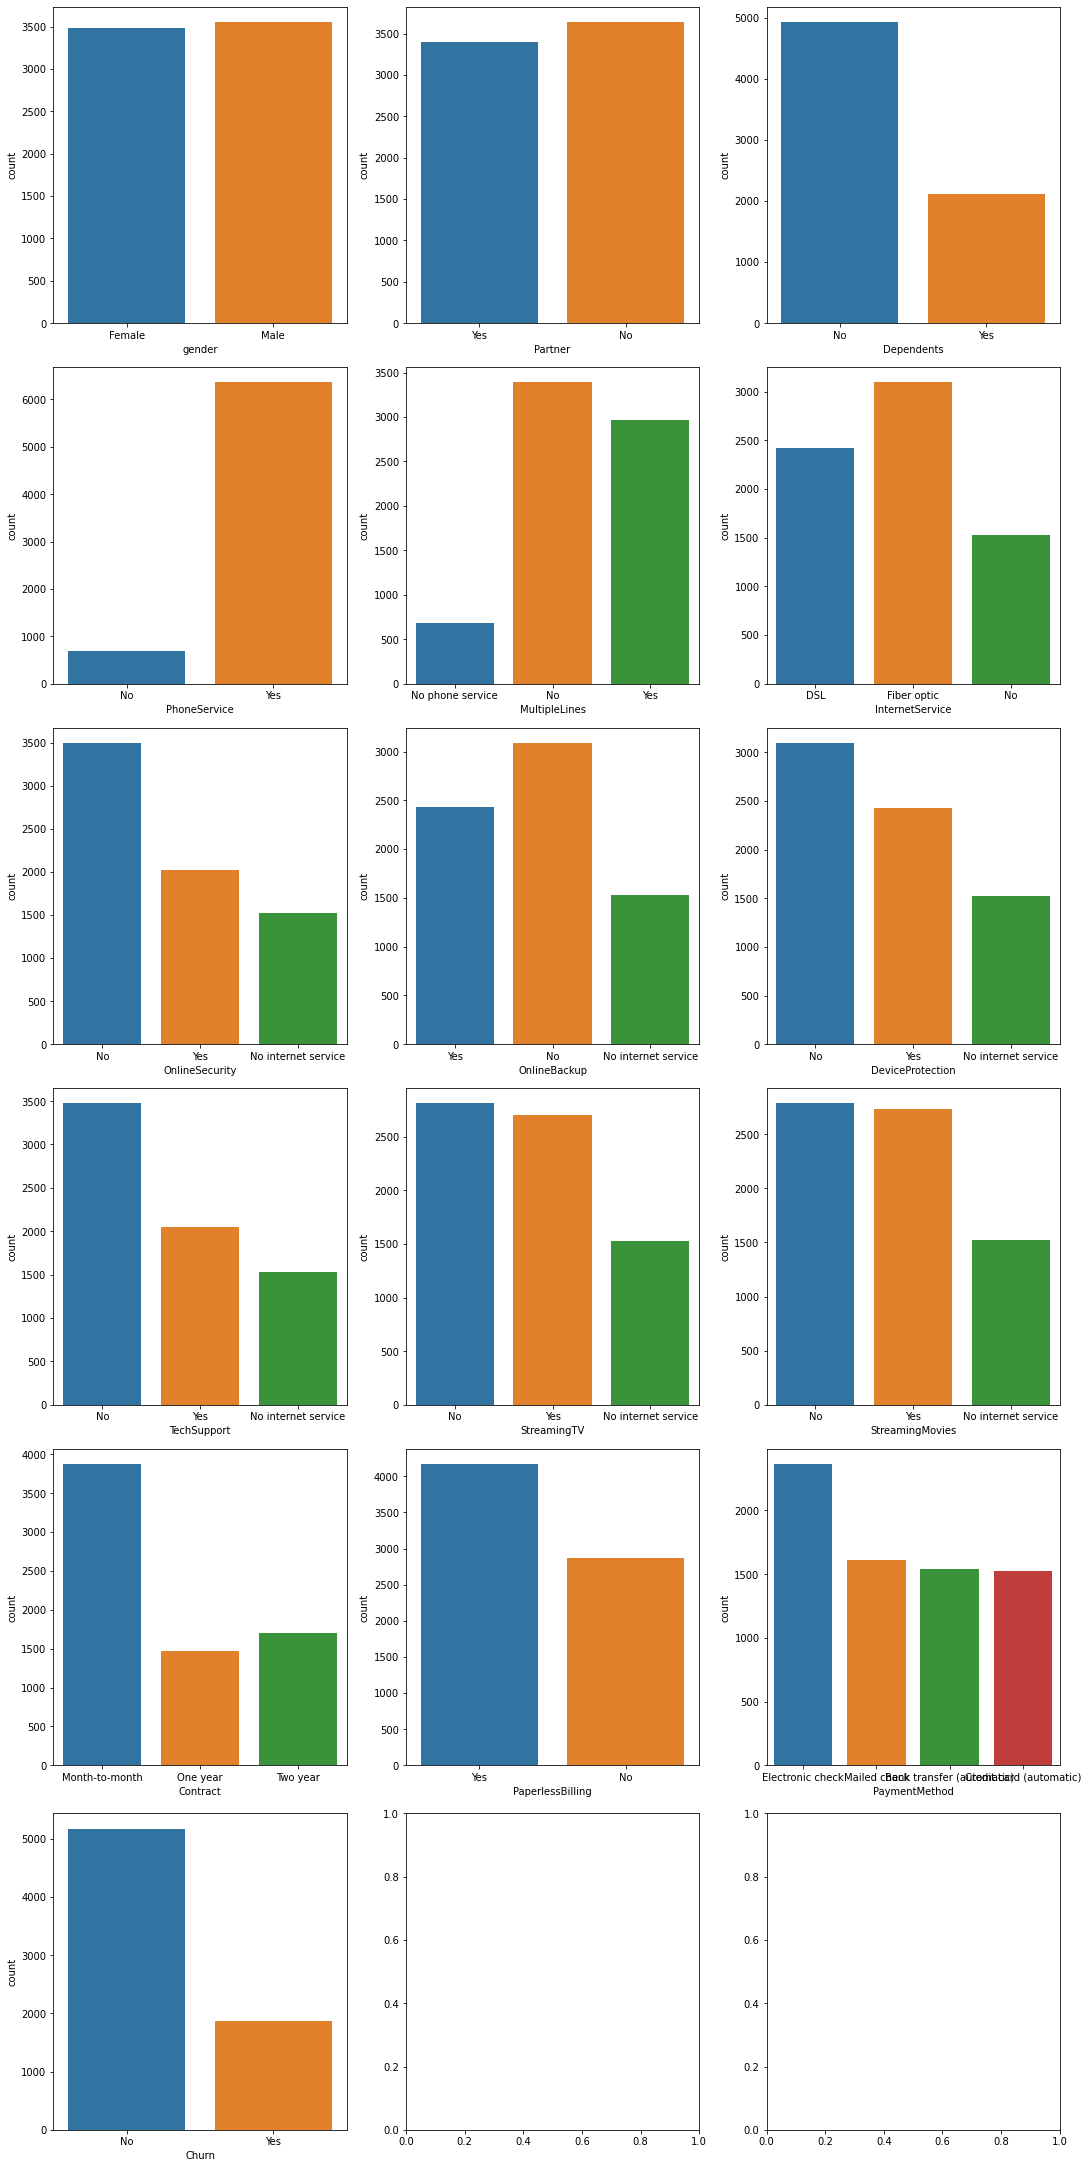

In [ ]:
# plot graph for all categorical columns
num_plots = len(obejct_col)
total_cols = 3 
total_rows = num_plots//total_cols +1 
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,figsize=(5*total_cols, 5*total_rows), constrained_layout=True)

for i, col in enumerate(obejct_col):
  row = i//total_cols
  pos = i% total_cols
  plot = sns.countplot(x = col, data= df,ax=axs[row][pos])

***Teste de Hipótese setup***

In [ ]:
# packages 
import scipy.stats as stats
from scipy.stats import mannwhitneyu, ttest_ind

In [ ]:
# Shapiro wilk - verificar se é normal
def e_normal(group):
  wval, pval = stats.shapiro(group)
  if len(group) > 5000:
      if wval <0.05: return False 
  if pval < 0.05: return False
  return True

# equal variance test
def var_igual(group1,group2):
  _,pval = stats.levene(group1,group2)
  if pval<0.05: return False 
  return True 

# teste de hipótese
def stats_test(group1, group2):
  if e_normal(group1) and e_normal(group2):
    if var_igual(group1,group2):
      print("Realizando t-test...")
      return stats.ttest_ind(group1,group2)
    print("Relizando t-test com variancia diferente...")
    return stats.ttest_ind(group1,group2, equal_var = False)
  print("Realizando U-Test...")
  return mannwhitneyu(group1,group2)

##**Contracts**
**A maioria dos contratos é mês a mês**

É mais fácil cancelar um serviço em contratos de curta duração, ***a compania deve se esforçar para conseguir clientes que optem por contratos longos***, para não somente evitar o churn, mas também **ter mais receita previsível.**

In [ ]:
# create churn dataset
df_churn= df[df.Churn == "Yes" ]

In [ ]:
# created dataset for no churn 
df_nochurn= df[df.Churn == "No" ]

In [ ]:
# proportion of month-to-month contracts in the general dataset 
contract_general = (df[df.Contract=='Month-to-month'].value_counts().shape[0]/df.shape[0])*100

# proportion of month-to-month contracts for clients that churn  
contract_churn = (df_churn[df_churn.Contract=='Month-to-month'].value_counts().shape[0]/df_churn.shape[0])*100

# proportion of month-to-month contracts for clients that did not churn  
contract_nochurn = (df[(df.Churn=='No') & (df.Contract=='Month-to-month')].shape[0]/df[df.Churn=='No'].shape[0])*100

Porcentage of monthly contracts: 55.02%
Porcentage of monthly contracts of clients that did not churn: 42.91%
Porcentage of monthly contracts of clients that churn: 88.55%


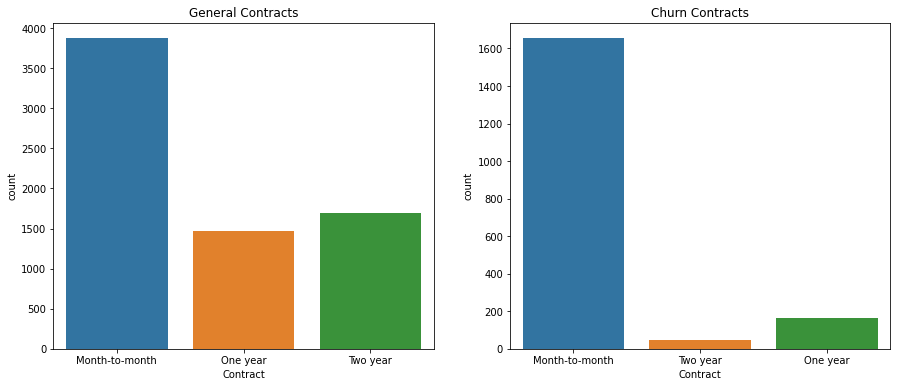

In [ ]:
print('Porcentage of monthly contracts: {:.2f}%'.format(contract_general))
print('Porcentage of monthly contracts of clients that did not churn: {:.2f}%'.format(contract_nochurn))
print('Porcentage of monthly contracts of clients that churn: {:.2f}%'.format(contract_churn))

# graph comparison
fig, (ax1,ax2) = plt.subplots(nrows= 1,ncols=2,figsize=(15,6))
sns.countplot(x="Contract", data =df,ax=ax1)
ax1.set_title("General Contracts")
sns.countplot(x="Contract", data =df_churn,ax=ax2)
ax2.set_title("Churn Contracts")

plt.show()

**Teste de Hipótese de tipos de contrato - Clientes Churn**

* *H0* - em contratos curtos os clientes ficam mais tempo 
* *HA* - em contratos longos os clientes ficam mais tempo

In [ ]:
# churn clients with short contracts
churn_short = df_churn[df_churn.Contract == 'Month-to-month']
churn_short_mean =  churn_short['tenure'].mean()

# churn clients with long contracts
churn_long = df_churn[df_churn.Contract != 'Month-to-month']
churn_long_mean = churn_long['tenure'].mean()

print("Clientes Chrun\nTenure médio de contratos curtos: {:.2f}\nTenure médio de contratos longos: {:.2f}".format(churn_short_mean,churn_long_mean))


Clientes Chrun
Tenure médio de contratos curtos: 14.02
Tenure médio de contratos longos: 48.62


In [ ]:
# select group
group1 = churn_long['tenure']
group2 = churn_short['tenure']

# testar hypotese
stats_test(group1,group2)

Realizando U-Test...


MannwhitneyuResult(statistic=32340.5, pvalue=1.3288923043838296e-85)

*p-value < 0.05 - H0 rejeitada*

**Teste de Hipótese de tipos de contrato - Clientes Ativos**

* *H0* - em contratos curtos os clientes ficam mais tempo 
* *HA* - em contratos longos os clientes ficam mais tempo

In [ ]:
# active clients with short contracts
active_short = df_nochurn[df_nochurn.Contract == 'Month-to-month']
active_short_mean_tenure = active_short['tenure'].mean()

# active clients with long contracts
active_long = df_nochurn[df_nochurn.Contract != 'Month-to-month']
active_long_mean_tenure = active_long['tenure'].mean()

print("Clientes Ativos\nTenure médio de contratos curtos: {:.2f}\nTenure médio de contratos longos: {:.2f}".format(active_short_mean_tenure,active_long_mean_tenure))


Clientes Ativos
Tenure médio de contratos curtos: 21.03
Tenure médio de contratos longos: 50.00


In [ ]:
# test hypothesis 
group1 = active_long['tenure']
group1 = active_short['tenure']

stats_test(group1,group2)

Realizando U-Test...


MannwhitneyuResult(statistic=1363037.5, pvalue=1.4577752849245383e-43)

*p-value < 0.05 - H0 rejeitada*

## Partner

Para a emoresa, talvez seja ideal ter clientes que tenham parceiros, porque se um não usa mas o outro usa, ***eles irão considerar mais antes de cancelar.***


* Clientes ativos:
  * 52.82% tem parceiro 
* Clientes **churn:**
  * **Somente 35.79% tem parceiro** 

In [ ]:
# partner proporcion churn 
partner_churn_yes = (df_churn[df_churn.Partner=='Yes'].shape[0]/df_churn.shape[0])*100
partner_churn_no = (df_churn[df_churn.Partner=='No'].shape[0]/df_churn.shape[0])*100

# partner proporcion no churn 
partner_nochurn_yes = (df_nochurn[df_nochurn.Partner=='Yes'].shape[0]/df_nochurn.shape[0])*100
partner_nochurn_no = (df_nochurn[df_nochurn.Partner=='No'].shape[0]/df_nochurn.shape[0])*100

# print results
print('Clients that didnt churn:\n {:.2f}% had a partner and {:.2f} did not\nClients that churn:\n {:.2f}% had a partner and {:.2f} did not'.format(partner_nochurn_yes,partner_nochurn_no,partner_churn_yes,partner_churn_no))

Clients that didnt churn:
 52.82% had a partner and 47.18 did not
Clients that churn:
 35.79% had a partner and 64.21 did not


**Teste de Hipótese com/sem parceiros - Clientes Churn**

* *H0* - clientes sem parceiro ficam mais tempo 
* *HA* - clientes com parceiro ficam mais tempo

In [ ]:
# clientes churn com parceiros 
churn_partner_yes = df_churn[df_churn.Partner=='Yes']
churn_partner_yes_tenure = churn_partner_yes['tenure'].mean()

# clientes churn sem parceiros 
churn_partner_no = df_churn[df_churn.Partner=='No']
churn_partner_no_tenure = churn_partner_no['tenure'].mean()

print("Clientes Churn\nTenure médio de clientes com parceiros: {:.2f}\nTenure médio de clientes sem parceiross: {:.2f}".format(churn_partner_yes_tenure,churn_partner_no_tenure))

Clientes Churn
Tenure médio de clientes com parceiros: 26.59
Tenure médio de clientes sem parceiross: 13.18


In [ ]:
# test churn clients - with partner and without partner
group1 = churn_partner_yes['tenure']
group2 = churn_partner_no['tenure']

stats_test(group1,group2)

Realizando U-Test...


MannwhitneyuResult(statistic=242618.0, pvalue=1.9182530357485226e-46)

*p-value < 0.05 - H0 rejeitada*

**Teste de Hipótese com/sem parceiros - Clientes Ativos**

* *H0* - clientes sem parceiro ficam mais tempo 
* *HA* - clientes com parceiro ficam mais tempo

In [ ]:
# Clientes ativos com parceiros
active_partner_yes = df_nochurn[df_nochurn.Partner=='Yes']
active_partner_yes_tenure = active_partner_yes['tenure'].mean()

# Clientes ativos sem parceiros
active_partner_no = df_nochurn[df_nochurn.Partner=='No']
active_partner_no_tenure = active_partner_no['tenure'].mean()

print("Clientes Ativos\nTenure médio de clientes com parceiros: {:.2f}\nTenure médio de clientes sem parceiross: {:.2f}".format(active_partner_yes_tenure,active_partner_no_tenure))

Clientes Ativos
Tenure médio de clientes com parceiros: 45.79
Tenure médio de clientes sem parceiross: 28.36


In [ ]:
# test active clients - with partner and without partner
group1 = active_partner_yes['tenure']
group2 = active_partner_no['tenure']

stats_test(group1,group2)

Realizando U-Test...


MannwhitneyuResult(statistic=1925559.5, pvalue=1.0438552677385367e-152)

*p-value < 0.05 - H0 rejeitada*

## Dependents
**A maioria não tem dependentes** - isso pode gerar o mesmo efeito mensionado anteriormente

* Clientes **Ativos**:
 * **34.48%** tem dependentes 
* Clientes **Churn**:
 * **17.44%** tem dependentes

In [ ]:
# partner proporcion no churn 
dependent_nochurn_yes = (df_nochurn[df_nochurn.Dependents=='Yes'].shape[0]/df_nochurn.shape[0])*100
dependent_nochurn_no = (df_nochurn[df_nochurn.Dependents=='No'].shape[0]/df_nochurn.shape[0])*100

# partner proporcion churn 
dependent_churn_yes = (df_churn[df_churn.Dependents=='Yes'].shape[0]/df_churn.shape[0])*100
dependent_churn_no = (df_churn[df_churn.Dependents=='No'].shape[0]/df_churn.shape[0])*100

# print results
print('Clients that didnt churn:\n {:.2f}% had dependents and {:.2f} did not\nClients that churn:\n {:.2f}% had dependents and {:.2f} did not'.format(dependent_nochurn_yes,dependent_nochurn_no,dependent_churn_yes,dependent_churn_no))

Clients that didnt churn:
 34.48% had dependents and 65.52 did not
Clients that churn:
 17.44% had dependents and 82.56 did not


* **Churn customers had far fewer dependents than those who stayed with the service**

**Teste de Hipótese com/sem dependentes - Clientes Chrun**

* *H0* - clientes sem dependentes ficam mais tempo 
* *HA* - clientes com dependentes ficam mais tempo

In [ ]:
# clientes churn com dependentes churn tenure medio
churn_dep_yes = df_churn[df_churn.Dependents=='Yes']
churn_dep_yes_tenure = churn_dep_yes['tenure'].mean()

# clientes churn sem dependentes tenure medio
churn_dep_no = df_churn[df_churn.Dependents=='No']
churn_dep_no_tenure = churn_dep_no['tenure'].mean()

print("Clientes Churn\nTenure médio de clientes com dependentes: {:.2f}\nTenure médio de clientes sem dependentes: {:.2f}".format(churn_dep_yes_tenure,churn_dep_no_tenure))

Clientes Churn
Tenure médio de clientes com dependentes: 22.03
Tenure médio de clientes sem dependentes: 17.12


In [ ]:
# test dependents 
group1 = churn_dep_yes['tenure']
group2 = churn_dep_no['tenure']

stats_test(group1,group2)

Realizando U-Test...


MannwhitneyuResult(statistic=217114.5, pvalue=4.760606974894272e-05)

*p-value < 0.05 - H0 rejeitada*

**Teste de Hipótese com/sem dependentes - Clientes Ativos**

* *H0* - clientes sem dependentes ficam mais tempo 
* *HA* - clientes com dependentes ficam mais tempo

In [ ]:
# clientes ativos com dependentes
active_dep_yes = df_nochurn[df_nochurn.Dependents=='Yes']
active_dep_yes_tenure = active_dep_yes['tenure'].mean()

# clientes ativos sem dependentes
active_dep_no = df_nochurn[df_nochurn.Dependents=='No']
active_dep_no_tenure = active_dep_no['tenure'].mean()

print("Clientes Ativos\nTenure médio de clientes com dependentes: {:.2f}\nTenure médio de clientes sem dependentes: {:.2f}".format(active_dep_yes_tenure,active_dep_no_tenure))

Clientes Ativos
Tenure médio de clientes com dependentes: 41.35
Tenure médio de clientes sem dependentes: 35.58


In [ ]:
group1 = active_dep_yes['tenure']
group2 = active_dep_no['tenure']

stats_test(group1,group2)

Realizando U-Test...


MannwhitneyuResult(statistic=2596526.5, pvalue=2.866516349730208e-17)

*p-value < 0.05 - H0 rejeitada*

## Payment Method
**Pagamento por conta enviada pelos correios é o segundo mais popular** 

Se tiver um alto voulme de churn por conta de clientes que não pagaram, **a empresa precisa criar uma estratégia para aumentar os pagamentos automáticos**. Hoje a maioria dos pagamentos é feito online, as vezes a pessoa não queria cancelar mas esqueceu de pagar. 

* Clientes **Ativos**:
 * **49.79%** automatic payment 
* Clientes **Churn**
 * **26.22%** automatic payment

In [ ]:
# partner proporcion churn 
payment_churn_mail = (df_churn[(df_churn.PaymentMethod =='Mailed check') |(df_churn.PaymentMethod =='Electronic check')].shape[0]/df_churn.shape[0])*100
payment_churn_nomail = (df_churn[(df_churn.PaymentMethod =='Credit card (automatic)') |(df_churn.PaymentMethod =='Bank transfer (automatic)')].shape[0]/df_churn.shape[0])*100

# partner proporcion no churn 
payment_nochurn_mail = (df_nochurn[(df_nochurn.PaymentMethod =='Mailed check') |(df_nochurn.PaymentMethod =='Electronic check')].shape[0]/df_nochurn.shape[0])*100
payment_nochurn_nomail = (df_nochurn[(df_nochurn.PaymentMethod =='Credit card (automatic)') |(df_nochurn.PaymentMethod =='Bank transfer (automatic)')].shape[0]/df_nochurn.shape[0])*100

# print results
print('Clients that didnt churn:\n {:.2f}% Mail {:.2f}% automatic\nClients that churn:\n {:.2f}% Mail and {:.2f}% automatic'.format(payment_nochurn_mail,payment_nochurn_nomail,payment_churn_mail,payment_churn_nomail))

Clients that didnt churn:
 50.21% Mail 49.79% automatic
Clients that churn:
 73.78% Mail and 26.22% automatic


* **Clients that churn had far less automatic payment methods**

**Teste de Hipótese com/sem dependentes - Clientes Churn**

* *H0* - clientes com pagamento não automático ficam mais tempo 
* *HA* - clientes com pagamento automático ficam mais tempo

In [ ]:
# clinets churn pagamento automatico 
churn_auto = df_churn[(df_churn.PaymentMethod =='Credit card (automatic)') | (df_churn.PaymentMethod =='Bank transfer (automatic)')]
churn_auto_mean_tenure = churn_auto['tenure'].mean()

# clinets churn pagamento manual
churn_mail = df_churn[(df_churn.PaymentMethod =='Mailed check') |(df_churn.PaymentMethod =='Electronic check')]
churn_mail_mean_tenure = churn_mail['tenure'].mean()

print("Clientes Churn\nTenure médio de clientes com pagamento automático: {:.2f}\nTenure médio de clientes com pagamento manual: {:.2f}".format(churn_auto_mean_tenure,churn_mail_mean_tenure))

Clientes Churn
Tenure médio de clientes com pagamento automático: 26.87
Tenure médio de clientes com pagamento manual: 14.82


In [ ]:
group1 = churn_auto['tenure']
group2 = churn_mail['tenure']

stats_test(group1,group2)

Realizando U-Test...


MannwhitneyuResult(statistic=214087.0, pvalue=4.319921764086194e-34)

*p-value < 0.05 - H0 rejeitada*

**Teste de Hipótese com/sem dependentes - Clientes Ativos**

* *H0* - clientes com pagamento não automático ficam mais tempo 
* *HA* - clientes com pagamento automático ficam mais tempo

In [ ]:
# clientes ativos pagamento automatico
active_auto = df_nochurn[(df_nochurn.PaymentMethod =='Credit card (automatic)') |(df_nochurn.PaymentMethod =='Bank transfer (automatic)')]
active_auto_mean_tenure = active_auto['tenure'].mean()

# clientes ativos pagamento manual
active_mail = df_nochurn[(df_nochurn.PaymentMethod =='Mailed check') |(df_nochurn.PaymentMethod =='Electronic check')]
active_mail_mean_tenure = active_mail['tenure'].mean()

print("Clientes Ativos\nTenure médio de clientes com pagamento automático: {:.2f}\nTenure médio de clientes com pagamento manual: {:.2f}".format(active_auto_mean_tenure,active_mail_mean_tenure))

Clientes Ativos
Tenure médio de clientes com pagamento automático: 46.62
Tenure médio de clientes com pagamento manual: 28.60


In [ ]:
group1 = active_auto['tenure']
group1 = active_mail['tenure']
stats_test(group1,group2)

Realizando U-Test...


MannwhitneyuResult(statistic=1091167.5, pvalue=2.4736313270185257e-92)

*p-value < 0.05 - H0 rejeitada*